In [47]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
faturamento_df = pd.read_csv("data/faturamento_lojas_atuais.csv")
lojas_df = pd.read_csv("data/lojas_atuais.csv")

### Tratamento dos dados

In [3]:
faturamento_df["datetime"] = pd.to_datetime(faturamento_df.ano*100 + faturamento_df.mes, format='%Y%m')
fat_df = faturamento_df.groupby(["cod_loja", "datetime"] , as_index=False).sum()
fat_df.drop(["ano", "mes", "qtde"], axis=1, inplace=True)

df = fat_df.merge(lojas_df, left_on="cod_loja", right_on="cod_loja")
df["quarter"] = df["datetime"].dt.quarter
df["ano"] = df["datetime"].dt.year
df["mes"] = df["datetime"].dt.month
df["feature_03"] = df["feature_03"].apply(lambda x: 1 if x else 0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   cod_loja       73644 non-null  int64         
 1   datetime       73644 non-null  datetime64[ns]
 2   receita        73644 non-null  float64       
 3   cod_ap         73644 non-null  int64         
 4   cod_municipio  73644 non-null  int64         
 5   feature_01     26972 non-null  object        
 6   feature_02     73644 non-null  object        
 7   feature_03     73644 non-null  int64         
 8   feature_04     73644 non-null  float64       
 9   feature_05     73644 non-null  object        
 10  feature_06     73644 non-null  int64         
 11  feature_07     73644 non-null  float64       
 12  feature_08     73644 non-null  float64       
 13  feature_09     73644 non-null  float64       
 14  feature_10     73644 non-null  float64       
 15  feature_11     5849

In [5]:
has_na_cols = list()
for col in df.columns:
    if df[col].isnull().values.any():
        has_na_cols.append(col)
has_na_cols

['feature_01',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18']

In [6]:
for na_col in has_na_cols:
    if df[na_col].dtype == object:
        print(df[na_col].mode()[0])
        df[na_col].fillna(df[na_col].mode()[0], inplace=True)
    else:
        df[na_col].fillna(df[na_col].median(), inplace=True)

FEATURE_01_VALUE_10
FEATURE_11_VALUE_02
FEATURE_12_VALUE_01


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73644 entries, 0 to 73643
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   cod_loja       73644 non-null  int64         
 1   datetime       73644 non-null  datetime64[ns]
 2   receita        73644 non-null  float64       
 3   cod_ap         73644 non-null  int64         
 4   cod_municipio  73644 non-null  int64         
 5   feature_01     73644 non-null  object        
 6   feature_02     73644 non-null  object        
 7   feature_03     73644 non-null  int64         
 8   feature_04     73644 non-null  float64       
 9   feature_05     73644 non-null  object        
 10  feature_06     73644 non-null  int64         
 11  feature_07     73644 non-null  float64       
 12  feature_08     73644 non-null  float64       
 13  feature_09     73644 non-null  float64       
 14  feature_10     73644 non-null  float64       
 15  feature_11     7364

## Adicionar a receita do ultimo trimestre

In [8]:
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,quarter,ano,mes
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,FEATURE_12_VALUE_01,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,1
1,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,FEATURE_12_VALUE_01,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,2
2,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,FEATURE_12_VALUE_01,100.0,86.9,100.0,100.0,91.1,90.5,1,2016,3
3,1,2016-04-01,534618.84,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,FEATURE_12_VALUE_01,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,4
4,1,2016-05-01,595477.92,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,FEATURE_12_VALUE_01,100.0,86.9,100.0,100.0,91.1,90.5,2,2016,5


In [9]:
##loja_1_df = df[df["cod_loja"] == np.random.choice(df["cod_loja"].unique())]
##t = loja_1_df.sort_values(["cod_loja", "datetime"]).reset_index().head(30)
#print(t.head(30))

receita_ultimo_trimestre = []

for index, row in df.iterrows():
    if row["ano"] == 2016 and row["quarter"] == 1:
        receita_ultimo_trimestre.append([index, 0,0,0,0])
    # Há semestre anterior
    else:
        #ultimo trimestre do ano passado
        quarter = row["quarter"] - 1
        ano = row["ano"]
        
        if quarter == 0:
            ano = row["ano"]-1
            quarter = 4
            
        last_quarter_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["quarter"] == quarter) & (df["ano"] == ano)] \
                          .sort_values("datetime")[["datetime", "receita"]]
        receita = last_quarter_df["receita"].values
        if len(receita) == 3:
            receita_ultimo_trimestre.append([index, receita[0], receita[1], receita[2], np.mean(receita)])
        else:
            ## rever
            receita_ultimo_trimestre.append([index, 0, 0, 0, 0])
            
    
receita_ultimo_trimestre_df = pd.DataFrame(receita_ultimo_trimestre, columns=["index", "receita_trim1", "receita_trim2", "receita_trim3", "receita_media"]).set_index("index")
receita_ultimo_trimestre_df.head()
df = df.merge(receita_ultimo_trimestre_df, left_index=True, right_index=True)

In [10]:
## receita no mesmo mês do ana passado
receita_ano_passado = []

for index, row in df.iterrows():
    year_ago = row["datetime"].replace(year=row["ano"]-1)
    
    year_agora_df = df[(df["cod_loja"] == row["cod_loja"]) & (df["datetime"] == year_ago)]
    
    if year_agora_df.shape[0] == 1:
        receita_ano_passado.append([index, year_agora_df["receita"].values[0]])
    else:
        receita_ano_passado.append([index, 0])
        
receita_ultimo_ano_df = pd.DataFrame(receita_ano_passado, columns=["index", "receita_ano_passado"]).set_index("index")
receita_ultimo_ano_df.head()
df = df.merge(receita_ultimo_ano_df, left_index=True, right_index=True)

In [11]:
str_cols = list()
for col in df.columns.values.tolist():
    if df[col].dtype == object:
        str_cols.append(col)
        
str_cols
##df = pd.get_dummies(df, columns=str_cols)
##df.info()

['feature_01', 'feature_02', 'feature_05', 'feature_11', 'feature_12']

In [49]:
train_df = df[~df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]
test_df = df[df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]

In [50]:
str_cols = list()
for col in df.columns.values.tolist():
    if df[col].dtype == object:
        str_cols.append(col)
        
str_cols.append("datetime")
str_cols.append("receita")
str_cols.append("receita_trim1")
str_cols.append("receita_trim2")
str_cols.append("receita_trim3")

X_train = train_df.drop(str_cols, axis=1, errors="ignore")
y_train = train_df["receita"]

X_test = test_df.drop(str_cols, axis=1, errors="ignore")
y_test = test_df["receita"]

In [51]:
X_test.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'receita_media',
       'receita_ano_passado'],
      dtype='object')

In [52]:
X_train.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'receita_media',
       'receita_ano_passado'],
      dtype='object')

### Treinar o modelo

In [53]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train) 
np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

(8162.822331060812, 31211.37477856921)

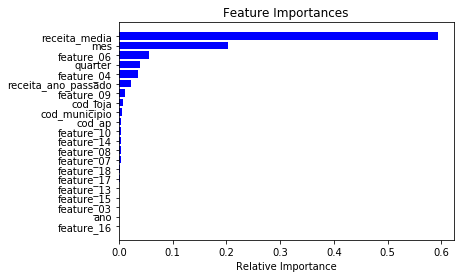

In [55]:
def print_feature_importances(model, cols):
    features = cols
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance');
    
print_feature_importances(rf, X_train.columns)  